In [149]:
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os

In [48]:
ROOT_PATH = '/home/hice1/cclark339/scratch/Data/single_nuc_1/'
DATA_PATH = ROOT_PATH + 'all_data_new_features_updated.csv'

TRAIN_VAL_BASE_PATH = ROOT_PATH + 'raw_data/training_data/YOLOV5_Cls_Manual_Videos/'

TRAIN_MID_PATH = TRAIN_VAL_BASE_PATH + 'train/'
VAL_MID_PATH = TRAIN_VAL_BASE_PATH + 'val/'

TRAIN_IMG_DIRS = [TRAIN_MID_PATH + 'Male/', TRAIN_MID_PATH + 'Female/']
VAL_IMG_DIRS = [VAL_MID_PATH + 'Male/', VAL_MID_PATH + 'Female/']

TEST_BASE_PATH = ROOT_PATH + 'raw_data/testing_data/test/'
TEST_IMG_DIRS = [TEST_BASE_PATH + 'male/', TEST_BASE_PATH + 'female/']

In [3]:
male_train_imgs = os.listdir(TRAIN_IMG_DIRS[0])
female_train_imgs = os.listdir(TRAIN_IMG_DIRS[1])

male_val_imgs = os.listdir(VAL_IMG_DIRS[0])
female_val_imgs = os.listdir(VAL_IMG_DIRS[1])

male_test_imgs = os.listdir(TEST_IMG_DIRS[0])
female_test_imgs = os.listdir(TEST_IMG_DIRS[1])

all_train_imgs = male_train_imgs + female_train_imgs
all_val_imgs = male_val_imgs + female_val_imgs
all_test_imgs = male_test_imgs + female_test_imgs

print(f'# of train images: {len(all_train_imgs)}')
print(f'# of val images: {len(all_val_imgs)}')
print(f'# of test images: {len(all_test_imgs)}')

# of train images: 662081
# of val images: 73704
# of test images: 1015185


In [4]:
male_train_ids = ['__'.join(img.split('__')[:-1]) for img in male_train_imgs]
female_train_ids = ['__'.join(img.split('__')[:-1]) for img in female_train_imgs]

all_train_ids = male_train_ids + female_train_ids
print(f'# train track IDs: {len(all_train_ids)}')

male_train_ids_set = set(male_train_ids)
female_train_ids_set = set(female_train_ids)

# train track IDs: 662081


In [5]:
male_val_ids = ['__'.join(img.split('__')[:-1]) for img in male_val_imgs]
female_val_ids = ['__'.join(img.split('__')[:-1]) for img in female_val_imgs]

all_val_ids = male_val_ids + female_val_ids
print(f'# val track IDs: {len(all_val_ids)}')

male_val_ids_set = set(male_val_ids)
female_val_ids_set = set(female_val_ids)

# val track IDs: 73704


In [6]:
male_test_ids = ['_'.join(img.split('_')[:-1]) for img in male_test_imgs]
female_test_ids = ['_'.join(img.split('_')[:-1]) for img in female_test_imgs]

all_test_ids = male_test_ids + female_test_ids
print(f'# test track IDs: {len(all_test_ids)}')

male_test_ids_set = set(male_test_ids)
female_test_ids_set = set(female_test_ids)

# test track IDs: 1015185


In [7]:
F = [male_train_ids_set, female_train_ids_set, male_val_ids_set, female_val_ids_set, male_test_ids_set, female_test_ids_set]

In [8]:
for i in range(0, len(F) - 1, 2):
    for j in range(1, len(F), 2):
        S_i = F[i]
        S_j = F[j]
        
        print(f'S_{i}, S_{j} overlap? {len(S_i & S_j) > 0}')

S_0, S_1 overlap? False
S_0, S_3 overlap? False
S_0, S_5 overlap? False
S_2, S_1 overlap? False
S_2, S_3 overlap? False
S_2, S_5 overlap? False
S_4, S_1 overlap? False
S_4, S_3 overlap? False
S_4, S_5 overlap? False


## YOLO Dataset Construction

In [9]:
total_df = pd.read_csv(DATA_PATH)
total_df

,unique_track_id,frame_num,track_type,true_label,yolov5_class_id,xc,yc,u_dot,v_dot,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity
0,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382058,train,0,0.0,117.405639,104.372970,6.973857,22.796302,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.000210,3.849834
1,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382059,train,0,0.0,123.302195,123.913192,6.585702,21.623125,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.000210,3.849834
2,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382068,train,0,0.0,111.683189,400.633206,-0.382109,28.731078,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.000210,3.849834
3,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382158,train,0,0.0,821.635502,527.801237,5.468046,-3.778739,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.000210,3.849834
4,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,383058,train,0,0.0,883.833486,309.388663,2.265553,0.529649,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.000210,3.849834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012917,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535063,test,0,0.0,113.216856,23.772530,-0.139779,-0.083265,1.223667,4692.119727,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
2012918,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535064,test,0,0.0,114.332797,22.259622,-0.026375,-0.212375,1.223667,4692.119727,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
2012919,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535065,test,0,0.0,113.453353,22.342868,-0.103404,-0.185682,1.223667,4692.119727,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
2012920,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535066,test,0,0.0,113.447966,23.034077,-0.094555,-0.106513,1.223667,4692.119727,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154


In [10]:
total_df.isna().any()

unique_track_id        False
frame_num              False
track_type             False
true_label             False
yolov5_class_id        False
xc                     False
yc                     False
u_dot                  False
v_dot                  False
speed                  False
distance_traveled      False
mean_acceleration      False
outreach_ratio         False
square_displacement    False
mean_turning_angle     False
jerk                   False
rms_velocity           False
dtype: bool

In [11]:
df_all_ids = set(total_df['unique_track_id'])

print(f'# of tracks in dataset: {len(df_all_ids)}')

# of tracks in dataset: 1086


In [12]:
trainval_df = total_df.loc[total_df['track_type'] == 'train']
trainval_df

,unique_track_id,frame_num,track_type,true_label,yolov5_class_id,xc,yc,u_dot,v_dot,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity
0,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382058,train,0,0.0,117.405639,104.372970,6.973857,22.796302,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
1,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382059,train,0,0.0,123.302195,123.913192,6.585702,21.623125,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
2,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382068,train,0,0.0,111.683189,400.633206,-0.382109,28.731078,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
3,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,382158,train,0,0.0,821.635502,527.801237,5.468046,-3.778739,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
4,MC_singlenuc23_1_Tk33_021220__0001_vid__1330,383058,train,0,0.0,883.833486,309.388663,2.265553,0.529649,2.669734,15439.795210,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950641,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350,537123,train,1,0.0,156.276651,671.360475,4.437002,6.482767,5.231545,1972.812041,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
950642,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350,537124,train,1,0.0,162.206921,672.395285,4.571728,5.991240,5.231545,1972.812041,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
950643,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350,537125,train,1,0.0,170.841343,672.257588,4.938269,5.438280,5.231545,1972.812041,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
950644,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350,537126,train,1,0.0,178.862178,673.323482,5.216379,5.043803,5.231545,1972.812041,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525


In [13]:
expanded_train_df = []
for track_id in tqdm(np.unique(all_train_ids)):
    imgs = [img for img in all_train_imgs if track_id + '_' in img]
    
#     print(imgs.shape)
    
    
    row = trainval_df.loc[trainval_df['unique_track_id'] == track_id].iloc[0]
    tmp = [['Male/' + img if row['true_label'] == 1 else 'Female/' + img, 'train', row['true_label'], row['distance_traveled'], row['speed'], row['mean_acceleration'], row['outreach_ratio'], row['square_displacement'], row['mean_turning_angle'], row['jerk'], row['rms_velocity']] for img in imgs]
    
    expanded_train_df += tmp
    

100%|██████████| 628/628 [01:15<00:00,  8.33it/s]


In [14]:
expanded_train_df = pd.DataFrame.from_records(expanded_train_df, columns=['filepath', 'split', 'is_male', 'distance', 'speed', 'acceleration', 'outreach_ratio', 'sqr_displacement', 'mean_turning_angle', 'jerk', 'rms_velocity'])
expanded_train_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity
0,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
1,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
2,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
3,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
4,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
...,...,...,...,...,...,...,...,...,...,...,...
662076,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,train,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
662077,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,train,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
662078,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,train,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
662079,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,train,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525


In [15]:
expanded_train_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/expanded_training_set.csv', index=False)

In [16]:
expanded_val_df = []
for track_id in tqdm(np.unique(all_val_ids)):
    imgs = [img for img in all_val_imgs if track_id + '_' in img]

    row = trainval_df.loc[trainval_df['unique_track_id'] == track_id].iloc[0]
    tmp = [['Male/' + img if row['true_label'] == 1 else 'Female/' + img, 'val', row['true_label'], row['distance_traveled'], row['speed'], row['mean_acceleration'], row['outreach_ratio'], row['square_displacement'], row['mean_turning_angle'], row['jerk'], row['rms_velocity']] for img in imgs]
    
    expanded_val_df += tmp

100%|██████████| 618/618 [00:31<00:00, 19.46it/s]


In [17]:
expanded_val_df = pd.DataFrame.from_records(expanded_val_df, columns=['filepath', 'split', 'is_male', 'distance', 'speed', 'acceleration', 'outreach_ratio', 'sqr_displacement', 'mean_turning_angle', 'jerk', 'rms_velocity'])
expanded_val_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity
0,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,val,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
1,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,val,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
2,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,val,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
3,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,val,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
4,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,val,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834
...,...,...,...,...,...,...,...,...,...,...,...
73699,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
73700,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
73701,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525
73702,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525


In [18]:
expanded_val_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/expanded_validation_set.csv', index=False)

In [19]:
test_df = total_df.loc[total_df['track_type'] == 'test']
test_df

,unique_track_id,frame_num,track_type,true_label,yolov5_class_id,xc,yc,u_dot,v_dot,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity
950646,MC_singlenuc62_3_Tk65_060220__0001_vid__1602,119735,test,1,0.0,0.487516,0.959091,4.070835,-4.832684,5.275686,18.049692,0.364641,8.830518e-07,0.179105,0.054888,-0.000580,6.427450
950647,MC_singlenuc62_3_Tk65_060220__0001_vid__1602,119736,test,1,0.0,0.488613,0.948572,3.116560,-6.775233,5.275686,18.049692,0.364641,8.830518e-07,0.179105,0.054888,-0.000580,6.427450
950648,MC_singlenuc62_3_Tk65_060220__0001_vid__1602,119737,test,1,0.0,0.491099,0.941041,3.145261,-6.924879,5.275686,18.049692,0.364641,8.830518e-07,0.179105,0.054888,-0.000580,6.427450
950649,MC_singlenuc62_3_Tk65_060220__0001_vid__1602,119738,test,1,0.0,0.494843,0.931517,3.524060,-7.442532,5.275686,18.049692,0.364641,8.830518e-07,0.179105,0.054888,-0.000580,6.427450
950650,MC_singlenuc62_3_Tk65_060220__0001_vid__1602,119739,test,1,0.0,0.499262,0.917409,3.936836,-8.617140,5.275686,18.049692,0.364641,8.830518e-07,0.179105,0.054888,-0.000580,6.427450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012917,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535063,test,0,0.0,113.216856,23.772530,-0.139779,-0.083265,1.223667,4692.119727,0.150978,1.036571e-01,50341.782496,0.234763,-0.000308,2.542154
2012918,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535064,test,0,0.0,114.332797,22.259622,-0.026375,-0.212375,1.223667,4692.119727,0.150978,1.036571e-01,50341.782496,0.234763,-0.000308,2.542154
2012919,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535065,test,0,0.0,113.453353,22.342868,-0.103404,-0.185682,1.223667,4692.119727,0.150978,1.036571e-01,50341.782496,0.234763,-0.000308,2.542154
2012920,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,535066,test,0,0.0,113.447966,23.034077,-0.094555,-0.106513,1.223667,4692.119727,0.150978,1.036571e-01,50341.782496,0.234763,-0.000308,2.542154


In [20]:
expanded_test_df = []
for track_id in tqdm(np.unique(all_test_ids)):
    imgs = [img for img in all_test_imgs if track_id + '_' in img]    
    
    row = test_df.loc[test_df['unique_track_id'] == track_id].iloc[0]
    tmp = [['male/' + img if row['true_label'] == 1 else 'female/' + img, 'test', row['true_label'], row['distance_traveled'], row['speed'], row['mean_acceleration'], row['outreach_ratio'], row['square_displacement'], row['mean_turning_angle'], row['jerk'], row['rms_velocity']] for img in imgs]
    
    expanded_test_df += tmp

100%|██████████| 457/457 [01:18<00:00,  5.79it/s]


In [21]:
expanded_test_df = pd.DataFrame.from_records(expanded_test_df, columns=['filepath', 'split', 'is_male', 'distance', 'speed', 'acceleration', 'outreach_ratio', 'sqr_displacement', 'mean_turning_angle', 'jerk', 'rms_velocity'])
expanded_test_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity
0,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
1,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
2,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
3,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
4,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
...,...,...,...,...,...,...,...,...,...,...,...
1015180,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
1015181,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
1015182,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
1015183,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154


In [22]:
expanded_test_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/expanded_testing_set.csv', index=False)

## Dataset Processing

In [23]:
expanded_trainval_df = pd.concat([expanded_train_df, expanded_val_df], axis=0).reset_index(drop=True)

expanded_trainval_df['filename'] = expanded_trainval_df['filepath'].apply(lambda x: x.split('/')[-1])
expanded_trainval_df['track_id'] = expanded_trainval_df['filename'].apply(lambda x: '__'.join(x.split('__')[:-1]))

expanded_trainval_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity,filename,track_id
0,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834,MC_singlenuc23_1_Tk33_021220__0001_vid__1330__...,MC_singlenuc23_1_Tk33_021220__0001_vid__1330
1,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834,MC_singlenuc23_1_Tk33_021220__0001_vid__1330__...,MC_singlenuc23_1_Tk33_021220__0001_vid__1330
2,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834,MC_singlenuc23_1_Tk33_021220__0001_vid__1330__...,MC_singlenuc23_1_Tk33_021220__0001_vid__1330
3,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834,MC_singlenuc23_1_Tk33_021220__0001_vid__1330__...,MC_singlenuc23_1_Tk33_021220__0001_vid__1330
4,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,train,0,15439.795210,2.669734,0.281946,0.074381,128467.100986,0.118348,-0.00021,3.849834,MC_singlenuc23_1_Tk33_021220__0001_vid__1330__...,MC_singlenuc23_1_Tk33_021220__0001_vid__1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735780,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350
735781,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350
735782,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350
735783,Male/MC_singlenuc96_b1_Tk41_081120__0001_vid__...,val,1,1972.812041,5.231545,0.443116,0.331928,28410.043847,0.060137,-0.00362,5.753525,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9350


In [24]:
N_trainval = len(expanded_trainval_df['track_id'].unique())
print(f'# unique IDs in the combined set: {N_trainval}')

# unique IDs in the combined set: 628


In [25]:
n_train = int(0.8 * N_trainval)
print(f'# unique IDs in new train split: {n_train}')

# unique IDs in new train split: 502


In [26]:
new_train_ids = np.random.choice(expanded_trainval_df['track_id'].unique(), n_train, replace=False)
print(f'Number of selected IDs = {n_train}? {len(new_train_ids) == n_train}')

Number of selected IDs = 502? True


In [27]:
new_expanded_train_df = []
for new_train_id in new_train_ids:
    new_expanded_train_df += expanded_trainval_df.loc[expanded_trainval_df['track_id'] == new_train_id].values.tolist()
    
new_expanded_train_df = pd.DataFrame.from_records(new_expanded_train_df, columns=expanded_trainval_df.columns)
new_expanded_train_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity,filename,track_id
0,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__5...,train,1,3157.177255,9.477585,0.717047,0.268440,67149.061139,0.051450,-0.010046,10.975412,MC_singlenuc62_3_Tk65_060220__0001_vid__561__1...,MC_singlenuc62_3_Tk65_060220__0001_vid__561
1,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__5...,train,1,3157.177255,9.477585,0.717047,0.268440,67149.061139,0.051450,-0.010046,10.975412,MC_singlenuc62_3_Tk65_060220__0001_vid__561__1...,MC_singlenuc62_3_Tk65_060220__0001_vid__561
2,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__5...,train,1,3157.177255,9.477585,0.717047,0.268440,67149.061139,0.051450,-0.010046,10.975412,MC_singlenuc62_3_Tk65_060220__0001_vid__561__1...,MC_singlenuc62_3_Tk65_060220__0001_vid__561
3,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__5...,train,1,3157.177255,9.477585,0.717047,0.268440,67149.061139,0.051450,-0.010046,10.975412,MC_singlenuc62_3_Tk65_060220__0001_vid__561__1...,MC_singlenuc62_3_Tk65_060220__0001_vid__561
4,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__5...,train,1,3157.177255,9.477585,0.717047,0.268440,67149.061139,0.051450,-0.010046,10.975412,MC_singlenuc62_3_Tk65_060220__0001_vid__561__8...,MC_singlenuc62_3_Tk65_060220__0001_vid__561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
588891,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__3...,val,1,3073.699191,5.889025,0.413899,0.211283,60082.306047,0.054011,-0.000003,7.922357,MC_singlenuc62_3_Tk65_060220__0001_vid__396__2...,MC_singlenuc62_3_Tk65_060220__0001_vid__396
588892,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__3...,val,1,3073.699191,5.889025,0.413899,0.211283,60082.306047,0.054011,-0.000003,7.922357,MC_singlenuc62_3_Tk65_060220__0001_vid__396__1...,MC_singlenuc62_3_Tk65_060220__0001_vid__396
588893,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__3...,val,1,3073.699191,5.889025,0.413899,0.211283,60082.306047,0.054011,-0.000003,7.922357,MC_singlenuc62_3_Tk65_060220__0001_vid__396__3...,MC_singlenuc62_3_Tk65_060220__0001_vid__396
588894,Male/MC_singlenuc62_3_Tk65_060220__0001_vid__3...,val,1,3073.699191,5.889025,0.413899,0.211283,60082.306047,0.054011,-0.000003,7.922357,MC_singlenuc62_3_Tk65_060220__0001_vid__396__3...,MC_singlenuc62_3_Tk65_060220__0001_vid__396


In [28]:
new_val_ids = list(set(expanded_trainval_df['track_id'].unique()) - set(new_train_ids))
n_val = len(new_val_ids)

print(f'# unique IDs in new val split: {n_val}')
print(f'# unique IDs in new val split + # unique IDs in new train split = {N_trainval}? {(n_train + n_val) == N_trainval}')

# unique IDs in new val split: 126
# unique IDs in new val split + # unique IDs in new train split = 628? True


In [29]:
new_expanded_val_df = []
for new_val_id in new_val_ids:
    new_expanded_val_df += expanded_trainval_df.loc[expanded_trainval_df['track_id'] == new_val_id].values.tolist()
    
new_expanded_val_df = pd.DataFrame.from_records(new_expanded_val_df, columns=expanded_trainval_df.columns)
new_expanded_val_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity,filename,track_id
0,Female/MC_singlenuc63_1_Tk9_060220__0005_vid__...,train,0,3552.908342,1.690321,0.211041,0.128829,31401.091643,0.183582,-0.000738,3.414717,MC_singlenuc63_1_Tk9_060220__0005_vid__2114__4...,MC_singlenuc63_1_Tk9_060220__0005_vid__2114
1,Female/MC_singlenuc63_1_Tk9_060220__0005_vid__...,train,0,3552.908342,1.690321,0.211041,0.128829,31401.091643,0.183582,-0.000738,3.414717,MC_singlenuc63_1_Tk9_060220__0005_vid__2114__8...,MC_singlenuc63_1_Tk9_060220__0005_vid__2114
2,Female/MC_singlenuc63_1_Tk9_060220__0005_vid__...,train,0,3552.908342,1.690321,0.211041,0.128829,31401.091643,0.183582,-0.000738,3.414717,MC_singlenuc63_1_Tk9_060220__0005_vid__2114__1...,MC_singlenuc63_1_Tk9_060220__0005_vid__2114
3,Female/MC_singlenuc63_1_Tk9_060220__0005_vid__...,train,0,3552.908342,1.690321,0.211041,0.128829,31401.091643,0.183582,-0.000738,3.414717,MC_singlenuc63_1_Tk9_060220__0005_vid__2114__4...,MC_singlenuc63_1_Tk9_060220__0005_vid__2114
4,Female/MC_singlenuc63_1_Tk9_060220__0005_vid__...,train,0,3552.908342,1.690321,0.211041,0.128829,31401.091643,0.183582,-0.000738,3.414717,MC_singlenuc63_1_Tk9_060220__0005_vid__2114__5...,MC_singlenuc63_1_Tk9_060220__0005_vid__2114
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146884,Female/MC_singlenuc28_1_Tk3_022520__0003_vid__...,val,0,5610.526415,2.207359,0.207192,0.108310,44858.719899,0.125008,-0.001778,3.391302,MC_singlenuc28_1_Tk3_022520__0003_vid__27144__...,MC_singlenuc28_1_Tk3_022520__0003_vid__27144
146885,Female/MC_singlenuc28_1_Tk3_022520__0003_vid__...,val,0,5610.526415,2.207359,0.207192,0.108310,44858.719899,0.125008,-0.001778,3.391302,MC_singlenuc28_1_Tk3_022520__0003_vid__27144__...,MC_singlenuc28_1_Tk3_022520__0003_vid__27144
146886,Female/MC_singlenuc28_1_Tk3_022520__0003_vid__...,val,0,5610.526415,2.207359,0.207192,0.108310,44858.719899,0.125008,-0.001778,3.391302,MC_singlenuc28_1_Tk3_022520__0003_vid__27144__...,MC_singlenuc28_1_Tk3_022520__0003_vid__27144
146887,Female/MC_singlenuc28_1_Tk3_022520__0003_vid__...,val,0,5610.526415,2.207359,0.207192,0.108310,44858.719899,0.125008,-0.001778,3.391302,MC_singlenuc28_1_Tk3_022520__0003_vid__27144__...,MC_singlenuc28_1_Tk3_022520__0003_vid__27144


In [30]:
observed_val_ids = set(new_expanded_val_df['track_id'].unique())
observed_train_ids = set(new_expanded_train_df['track_id'].unique())

print(f'# overlapping track IDs: {len(observed_val_ids & observed_train_ids)}')

# overlapping track IDs: 0


In [31]:
new_expanded_train_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/expanded_training_by_track_set.csv', index=False)
new_expanded_val_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/expanded_validation_by_track_set.csv', index=False)

In [32]:
new_expanded_test_df = expanded_test_df.iloc[::15].reset_index(drop=True)
new_expanded_test_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity
0,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
1,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
2,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
3,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
4,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
...,...,...,...,...,...,...,...,...,...,...,...
67674,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67675,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67676,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67677,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154


In [33]:
new_expanded_test_df.to_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/smaller_expanded_testing_set.csv', index=False)

In [34]:
new_expanded_train_df.isna().any()

filepath              False
split                 False
is_male               False
distance              False
speed                 False
acceleration          False
outreach_ratio        False
sqr_displacement      False
mean_turning_angle    False
jerk                  False
rms_velocity          False
filename              False
track_id              False
dtype: bool

In [35]:
new_expanded_val_df.isna().any()

filepath              False
split                 False
is_male               False
distance              False
speed                 False
acceleration          False
outreach_ratio        False
sqr_displacement      False
mean_turning_angle    False
jerk                  False
rms_velocity          False
filename              False
track_id              False
dtype: bool

In [37]:
new_expanded_test_df.isna().any()

filepath              False
split                 False
is_male               False
distance              False
speed                 False
acceleration          False
outreach_ratio        False
sqr_displacement      False
mean_turning_angle    False
jerk                  False
rms_velocity          False
dtype: bool

## EDA

In [27]:
tmp_df = pd.read_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/smaller_expanded_testing_set.csv')
tmp_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity
0,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
1,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
2,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
3,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
4,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916
...,...,...,...,...,...,...,...,...,...,...,...
67674,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67675,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67676,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154
67677,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154


In [30]:
tmp_df['filename'] = tmp_df['filepath'].apply(lambda x: x.split('/')[-1])
tmp_df['track_id'] = tmp_df['filename'].apply(lambda x: '_'.join(x.split('_')[:-1]))
tmp_df['project'] = tmp_df['track_id'].apply(lambda x: '_'.join(x.split('_')[:3]))

tmp_df

,filepath,split,is_male,distance,speed,acceleration,outreach_ratio,sqr_displacement,mean_turning_angle,jerk,rms_velocity,filename,track_id,project
0,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916,MC_singlenuc23_1_Tk33_021220__0004_vid__115_34...,MC_singlenuc23_1_Tk33_021220__0004_vid__115,MC_singlenuc23_1
1,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916,MC_singlenuc23_1_Tk33_021220__0004_vid__115_28...,MC_singlenuc23_1_Tk33_021220__0004_vid__115,MC_singlenuc23_1
2,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916,MC_singlenuc23_1_Tk33_021220__0004_vid__115_33...,MC_singlenuc23_1_Tk33_021220__0004_vid__115,MC_singlenuc23_1
3,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916,MC_singlenuc23_1_Tk33_021220__0004_vid__115_32...,MC_singlenuc23_1_Tk33_021220__0004_vid__115,MC_singlenuc23_1
4,male/MC_singlenuc23_1_Tk33_021220__0004_vid__1...,test,1,23589.076095,5.025806,0.449513,0.039682,270184.060313,0.076592,-0.000379,6.049916,MC_singlenuc23_1_Tk33_021220__0004_vid__115_34...,MC_singlenuc23_1_Tk33_021220__0004_vid__115,MC_singlenuc23_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67674,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,MC_singlenuc96_b1
67675,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,MC_singlenuc96_b1
67676,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,MC_singlenuc96_b1
67677,female/MC_singlenuc96_b1_Tk41_081120__0001_vid...,test,0,4692.119727,1.223667,0.150978,0.103657,50341.782496,0.234763,-0.000308,2.542154,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287_...,MC_singlenuc96_b1_Tk41_081120__0001_vid__9287,MC_singlenuc96_b1


(array([4053., 2448., 1411., 3928., 2254., 3450., 2535., 3056., 3033.,
        1584.,  335., 2201., 3219., 1734., 4956., 3562., 3165., 1129.,
        1931., 2363., 2390., 4792., 2513., 1814., 1598., 1685.,  540.]),
 array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
         4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
         9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
        14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
        19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
        24.07407407, 25.03703704, 26.        ]),
 <BarContainer object of 27 artists>)

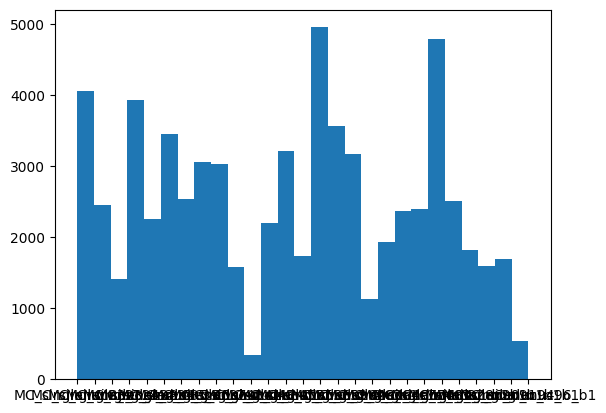

In [31]:
plt.hist(tmp_df['project'].values, bins=len(tmp_df['project'].unique()))

In [7]:
counts = tmp_df['track_id'].value_counts(ascending=True)
counts

track_id
MC_singlenuc94_b1_Tk31_081120__0001_vid__14066       1
MC_singlenuc43_11_Tk41_060220__0001_vid__434         1
MC_singlenuc94_b1_Tk31_081120__0001_vid__12632       1
MC_singlenuc36_2_Tk3_030320__0001_vid__15401         1
MC_singlenuc41_2_Tk9_030920__0001_vid__1935          3
                                                  ... 
MC_singlenuc23_1_Tk33_021220__0001_vid__2962      6638
MC_singlenuc23_1_Tk33_021220__0002_vid__12696     6639
MC_singlenuc28_1_Tk3_022520__0003_vid__24668      7950
MC_singlenuc82_b2_Tk63_073020__0001_vid__6657     8825
MC_singlenuc59_4_Tk61_060220__0001_vid__4920      8829
Name: count, Length: 502, dtype: int64

Text(0, 0.5, 'Track Length')

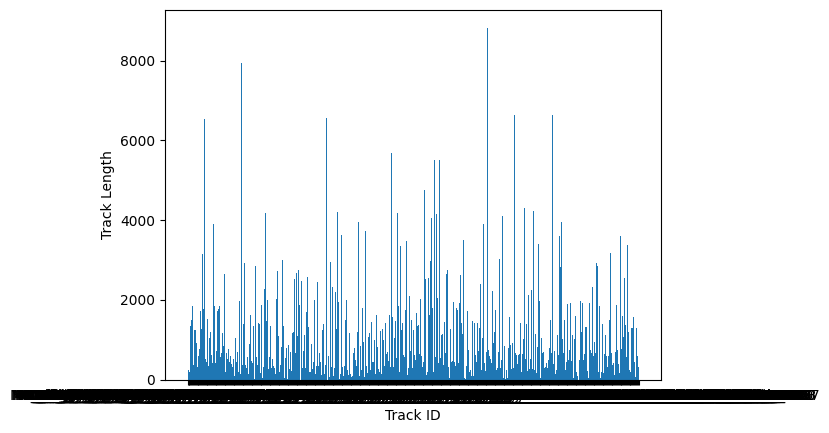

In [17]:
plt.hist(tmp_df['track_id'].values, bins=len(counts))
plt.xlabel('Track ID')
plt.ylabel('Track Length')

In [18]:
tmp_df = pd.read_csv('/home/hice1/cclark339/scratch/Data/single_nuc_1/training_set.csv')
tmp_df

,Unnamed: 0,filepath,distance,speed,acceleration,outreach_ratio,is_male
0,0,Male/MC_singlenuc56_2_Tk65_051220__0001_vid__1...,4381.099543,2.574854,0.224331,0.020457,1
1,1,Male/MC_singlenuc28_1_Tk3_022520__0003_vid__24...,25774.470593,1.936961,0.229371,0.010710,1
2,2,Male/MC_singlenuc81_1_Tk51_072920__0002_vid__1...,9768.326796,4.893891,0.420426,0.045643,1
3,3,Male/MC_singlenuc65_4_Tk9_072920__0002_vid__63...,25691.995169,6.581803,0.550099,0.005475,1
4,4,Male/MC_singlenuc59_4_Tk61_060220__0001_vid__4...,14129.662228,1.088585,0.120323,0.015835,1
...,...,...,...,...,...,...,...
662076,662076,Female/MC_singlenuc82_b2_Tk63_073020__0001_vid...,8682.332408,1.762028,0.174471,0.090294,0
662077,662077,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,10632.973318,2.646049,0.268153,0.021937,0
662078,662078,Female/MC_singlenuc23_1_Tk33_021220__0002_vid_...,6137.929312,2.021697,0.210424,0.143493,0
662079,662079,Female/MC_singlenuc56_2_Tk65_051220__0002_vid_...,4687.448829,2.592265,0.181941,0.103810,0


In [19]:
tmp_df['filename'] = tmp_df['filepath'].apply(lambda x: x.split('/')[-1])
tmp_df['track_id'] = tmp_df['filename'].apply(lambda x: '__'.join(x.split('__')[:-1]))

tmp_df

,Unnamed: 0,filepath,distance,speed,acceleration,outreach_ratio,is_male,filename,track_id
0,0,Male/MC_singlenuc56_2_Tk65_051220__0001_vid__1...,4381.099543,2.574854,0.224331,0.020457,1,MC_singlenuc56_2_Tk65_051220__0001_vid__1110__...,MC_singlenuc56_2_Tk65_051220__0001_vid__1110
1,1,Male/MC_singlenuc28_1_Tk3_022520__0003_vid__24...,25774.470593,1.936961,0.229371,0.010710,1,MC_singlenuc28_1_Tk3_022520__0003_vid__24668__...,MC_singlenuc28_1_Tk3_022520__0003_vid__24668
2,2,Male/MC_singlenuc81_1_Tk51_072920__0002_vid__1...,9768.326796,4.893891,0.420426,0.045643,1,MC_singlenuc81_1_Tk51_072920__0002_vid__1220__...,MC_singlenuc81_1_Tk51_072920__0002_vid__1220
3,3,Male/MC_singlenuc65_4_Tk9_072920__0002_vid__63...,25691.995169,6.581803,0.550099,0.005475,1,MC_singlenuc65_4_Tk9_072920__0002_vid__6327__2...,MC_singlenuc65_4_Tk9_072920__0002_vid__6327
4,4,Male/MC_singlenuc59_4_Tk61_060220__0001_vid__4...,14129.662228,1.088585,0.120323,0.015835,1,MC_singlenuc59_4_Tk61_060220__0001_vid__4920__...,MC_singlenuc59_4_Tk61_060220__0001_vid__4920
...,...,...,...,...,...,...,...,...,...
662076,662076,Female/MC_singlenuc82_b2_Tk63_073020__0001_vid...,8682.332408,1.762028,0.174471,0.090294,0,MC_singlenuc82_b2_Tk63_073020__0001_vid__7160_...,MC_singlenuc82_b2_Tk63_073020__0001_vid__7160
662077,662077,Female/MC_singlenuc23_1_Tk33_021220__0001_vid_...,10632.973318,2.646049,0.268153,0.021937,0,MC_singlenuc23_1_Tk33_021220__0001_vid__2085__...,MC_singlenuc23_1_Tk33_021220__0001_vid__2085
662078,662078,Female/MC_singlenuc23_1_Tk33_021220__0002_vid_...,6137.929312,2.021697,0.210424,0.143493,0,MC_singlenuc23_1_Tk33_021220__0002_vid__13039_...,MC_singlenuc23_1_Tk33_021220__0002_vid__13039
662079,662079,Female/MC_singlenuc56_2_Tk65_051220__0002_vid_...,4687.448829,2.592265,0.181941,0.103810,0,MC_singlenuc56_2_Tk65_051220__0002_vid__2520__...,MC_singlenuc56_2_Tk65_051220__0002_vid__2520


Text(0, 0.5, 'Track Length')

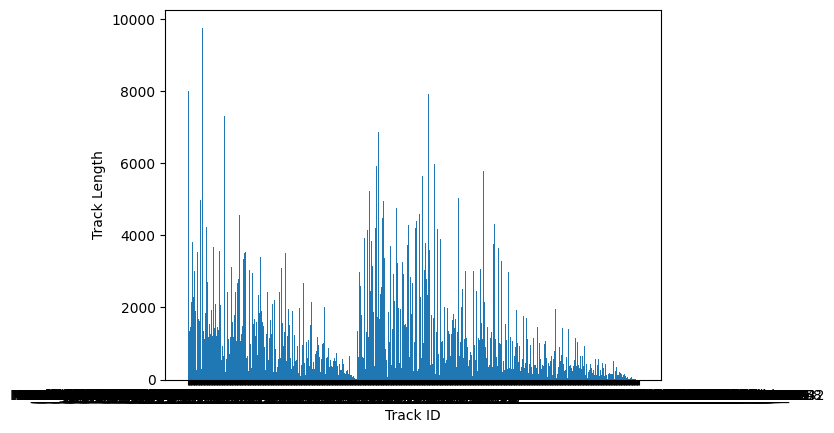

In [20]:
plt.hist(tmp_df['track_id'].values, bins=len(counts))
plt.xlabel('Track ID')
plt.ylabel('Track Length')

In [3]:
all_df = pd.read_csv(f'{ROOT_PATH}all_data_week15.csv').iloc[:, 1:]
all_df

,filepath,type,track_id,unique_track_id,frame_num,track_type,true_label,yolov5_class_id,xc,yc,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,MC_singlenuc56_2_Tk65_051220__0001_vid__1110__...,train,MC_singlenuc56_2_Tk65_051220__0001_vid__1110,MC_singlenuc56_2_Tk65_051220__0001_vid__1110,82540,train,1,0.0,483.667378,943.000832,...,1.0,0.052003,0.479232,0.091441,0.302391,-0.023657,40.433333,1.559743,0.048809,16
1,MC_singlenuc28_1_Tk3_022520__0003_vid__24668__...,train,MC_singlenuc28_1_Tk3_022520__0003_vid__24668,MC_singlenuc28_1_Tk3_022520__0003_vid__24668,936909,train,1,0.0,585.970324,778.866283,...,1.0,0.768707,0.938617,0.009271,0.096286,-0.257429,287.000000,1.749203,-0.257903,112
2,MC_singlenuc81_1_Tk51_072920__0002_vid__1220__...,train,MC_singlenuc81_1_Tk51_072920__0002_vid__1220,MC_singlenuc81_1_Tk51_072920__0002_vid__1220,42010,train,1,0.0,367.197862,347.477354,...,1.0,0.199118,0.720336,0.084297,0.290339,0.022592,46.900000,1.729582,0.010472,18
3,MC_singlenuc65_4_Tk9_072920__0002_vid__6327__2...,train,MC_singlenuc65_4_Tk9_072920__0002_vid__6327,MC_singlenuc65_4_Tk9_072920__0002_vid__6327,364882,train,1,0.0,1251.896355,451.708866,...,1.0,0.235576,0.725704,0.079120,0.281283,-0.292796,93.933333,1.764998,-0.295231,21
4,MC_singlenuc59_4_Tk61_060220__0001_vid__4920__...,train,MC_singlenuc59_4_Tk61_060220__0001_vid__4920,MC_singlenuc59_4_Tk61_060220__0001_vid__4920,265156,train,1,0.0,1130.683852,471.585334,...,1.0,0.731176,0.941009,0.013459,0.116015,-0.295676,264.400000,1.657222,-0.294608,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750965,MC_singlenuc40_2_Tk3_030920__0002_vid__26827__...,test,MC_singlenuc40_2_Tk3_030920__0002_vid__26827,MC_singlenuc40_2_Tk3_030920__0002_vid__26827,543996,test,0,0.0,694.322396,728.725823,...,1.0,0.390850,0.803196,0.052444,0.229006,0.012939,79.433333,1.663534,0.006394,56
1750966,MC_singlenuc62_3_Tk65_060220__0001_vid__14109_...,test,MC_singlenuc62_3_Tk65_060220__0001_vid__14109,MC_singlenuc62_3_Tk65_060220__0001_vid__14109,690787,test,0,1.0,0.197729,0.970145,...,1.0,0.668109,0.928741,0.020622,0.143603,-0.385219,63.633333,1.553945,-0.383232,1
1750967,MC_singlenuc65_4_Tk9_072920__0002_vid__6516__0...,test,MC_singlenuc65_4_Tk9_072920__0002_vid__6516,MC_singlenuc65_4_Tk9_072920__0002_vid__6516,372979,test,0,0.0,251.887146,419.816622,...,1.0,0.668509,0.875761,0.014573,0.120718,0.126716,37.300000,1.495753,0.079668,10
1750968,MC_singlenuc37_2_Tk17_030320__0001_vid__6866__...,test,MC_singlenuc37_2_Tk17_030320__0001_vid__6866,MC_singlenuc37_2_Tk17_030320__0001_vid__6866,292153,test,0,0.0,482.661286,30.080936,...,1.0,0.485514,0.884854,0.049418,0.222302,-0.178019,115.600000,1.744023,-0.173516,53


In [4]:
print(f'# unique track IDs: {all_df["track_id"].nunique()}')

# unique track IDs: 1085


In [5]:
print(f'# unique cross correlations with median smoothing: {all_df["cross_correlation_with_median_smoothing"].nunique()}')

# unique cross correlations with median smoothing: 1085


In [58]:
train_df = all_df.loc[all_df['type'] == 'train']
train_df

,filepath,type,track_id,unique_track_id,frame_num,track_type,true_label,yolov5_class_id,xc,yc,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,MC_singlenuc56_2_Tk65_051220__0001_vid__1110__...,train,MC_singlenuc56_2_Tk65_051220__0001_vid__1110,MC_singlenuc56_2_Tk65_051220__0001_vid__1110,82540,train,1,0.0,483.667378,943.000832,...,1.0,0.052003,0.479232,0.091441,0.302391,-0.023657,40.433333,1.559743,0.048809,16
1,MC_singlenuc28_1_Tk3_022520__0003_vid__24668__...,train,MC_singlenuc28_1_Tk3_022520__0003_vid__24668,MC_singlenuc28_1_Tk3_022520__0003_vid__24668,936909,train,1,0.0,585.970324,778.866283,...,1.0,0.768707,0.938617,0.009271,0.096286,-0.257429,287.000000,1.749203,-0.257903,112
2,MC_singlenuc81_1_Tk51_072920__0002_vid__1220__...,train,MC_singlenuc81_1_Tk51_072920__0002_vid__1220,MC_singlenuc81_1_Tk51_072920__0002_vid__1220,42010,train,1,0.0,367.197862,347.477354,...,1.0,0.199118,0.720336,0.084297,0.290339,0.022592,46.900000,1.729582,0.010472,18
3,MC_singlenuc65_4_Tk9_072920__0002_vid__6327__2...,train,MC_singlenuc65_4_Tk9_072920__0002_vid__6327,MC_singlenuc65_4_Tk9_072920__0002_vid__6327,364882,train,1,0.0,1251.896355,451.708866,...,1.0,0.235576,0.725704,0.079120,0.281283,-0.292796,93.933333,1.764998,-0.295231,21
4,MC_singlenuc59_4_Tk61_060220__0001_vid__4920__...,train,MC_singlenuc59_4_Tk61_060220__0001_vid__4920,MC_singlenuc59_4_Tk61_060220__0001_vid__4920,265156,train,1,0.0,1130.683852,471.585334,...,1.0,0.731176,0.941009,0.013459,0.116015,-0.295676,264.400000,1.657222,-0.294608,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662076,MC_singlenuc82_b2_Tk63_073020__0001_vid__7160_...,train,MC_singlenuc82_b2_Tk63_073020__0001_vid__7160,MC_singlenuc82_b2_Tk63_073020__0001_vid__7160,439600,train,0,0.0,799.496468,285.602435,...,1.0,0.700826,0.931662,0.017249,0.131335,0.388891,106.500000,1.668529,0.390635,47
662077,MC_singlenuc23_1_Tk33_021220__0001_vid__2085__...,train,MC_singlenuc23_1_Tk33_021220__0001_vid__2085,MC_singlenuc23_1_Tk33_021220__0001_vid__2085,445532,train,0,0.0,381.452900,35.652776,...,1.0,0.636700,0.915622,0.025007,0.158135,0.391710,86.933333,1.656496,0.376555,48
662078,MC_singlenuc23_1_Tk33_021220__0002_vid__13039_...,train,MC_singlenuc23_1_Tk33_021220__0002_vid__13039,MC_singlenuc23_1_Tk33_021220__0002_vid__13039,1107027,train,0,0.0,1153.553816,86.999929,...,1.0,0.625001,0.903502,0.024798,0.157474,-0.105177,64.633333,1.586054,-0.088710,24
662079,MC_singlenuc56_2_Tk65_051220__0002_vid__2520__...,train,MC_singlenuc56_2_Tk65_051220__0002_vid__2520,MC_singlenuc56_2_Tk65_051220__0002_vid__2520,169690,train,0,0.0,528.086376,945.031365,...,1.0,0.508252,0.857430,0.038399,0.195956,-0.387606,46.700000,1.567350,-0.391438,20


In [59]:
print(f'# training track IDs: {train_df["track_id"].nunique()}')

# training track IDs: 628


In [8]:
train_df.columns

Index(['filepath', 'type', 'track_id', 'unique_track_id', 'frame_num',
       'track_type', 'true_label', 'yolov5_class_id', 'xc', 'yc', 'u_dot',
       'v_dot', 'speed', 'distance_traveled', 'mean_acceleration',
       'outreach_ratio', 'square_displacement', 'mean_turning_angle', 'jerk',
       'rms_velocity', 'mean_autocorrelation', 'median_autocorrelation',
       'min_autocorrelation', 'max_autocorrelation', 'q1_autocorrelation',
       'q3_autocorrelation', 'var_autocorrelation', 'stddev_autocorrelation',
       'cross_correlation', 'duration', 'fractal_dimension',
       'cross_correlation_with_median_smoothing',
       'number_of_residence_patches'],
      dtype='object')

In [68]:
train_features = train_df.iloc[:, [6] + [idx for idx in range(12, len(train_df.columns))]].drop_duplicates().reset_index(drop=True)
train_labels = train_features.iloc[:, 0].reset_index(drop=True)

train_labels

0      1
1      1
2      1
3      1
4      1
      ..
623    0
624    0
625    0
626    0
627    0
Name: true_label, Length: 628, dtype: int64

In [69]:
train_features = train_features.iloc[:, 1:].reset_index(drop=True)
train_features

,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity,mean_autocorrelation,median_autocorrelation,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,2.574854,4381.099543,0.224331,0.165297,47878.245848,0.132677,-0.000140,4.279592,0.286562,0.165637,...,1.0,0.052003,0.479232,0.091441,0.302391,-0.023657,40.433333,1.559743,0.048809,16
1,1.936961,25774.470593,0.229371,0.032372,254245.515160,0.282413,-0.000105,3.380068,0.852886,0.856904,...,1.0,0.768707,0.938617,0.009271,0.096286,-0.257429,287.000000,1.749203,-0.257903,112
2,4.893891,9768.326796,0.420426,0.058363,113125.114308,0.078787,-0.000012,5.672029,0.469520,0.394907,...,1.0,0.199118,0.720336,0.084297,0.290339,0.022592,46.900000,1.729582,0.010472,18
3,6.581803,25691.995169,0.550099,0.035339,382587.354665,0.080028,-0.001552,7.730766,0.486699,0.416106,...,1.0,0.235576,0.725704,0.079120,0.281283,-0.292796,93.933333,1.764998,-0.295231,21
4,1.088585,14129.662228,0.120323,0.031818,57343.924027,0.224662,0.000022,1.620288,0.833532,0.840949,...,1.0,0.731176,0.941009,0.013459,0.116015,-0.295676,264.400000,1.657222,-0.294608,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,3.121293,4033.358601,0.282675,0.184728,37873.518037,0.133740,0.000055,4.121004,0.542709,0.512847,...,1.0,0.297284,0.779184,0.070118,0.264799,-0.085058,28.800000,1.534530,-0.108491,9
624,0.291744,3051.755141,0.067723,0.094277,8161.513423,0.458715,-0.000918,1.078791,0.758350,0.741646,...,1.0,0.706674,0.788205,0.004963,0.070448,0.193284,129.300000,1.302172,0.148416,2
625,3.697005,7384.469851,0.241364,0.111387,82592.779115,0.079538,-0.000063,5.052059,0.620081,0.611144,...,1.0,0.402926,0.835265,0.056033,0.236712,0.267154,53.233333,1.658648,0.294419,17
626,5.964125,9278.615351,0.444497,0.115771,142420.875159,0.062614,-0.000378,7.426744,0.382286,0.305127,...,1.0,0.105195,0.637685,0.100626,0.317216,-0.099218,39.066667,1.641895,-0.157444,11


In [120]:
scaler = StandardScaler()

X_scl = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)
X_scl

,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity,mean_autocorrelation,median_autocorrelation,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,-0.626124,-0.412592,-0.614693,-0.053483,-0.269957,0.654255,0.367557,-0.188269,-0.875091,-0.965052,...,0.0,-0.671058,-1.121508,0.191305,0.364973,-0.140123,-0.224122,0.124979,0.074068,-0.246407
1,-0.994944,4.319240,-0.575007,-1.180989,3.985287,3.507372,0.378119,-0.646405,1.474610,1.367183,...,0.0,1.553446,1.126571,-1.273463,-1.670578,-0.836634,5.287884,1.462837,-0.813661,3.917102
2,0.714712,0.778966,0.929495,-0.960528,1.075418,-0.372574,0.406658,0.520911,-0.115989,-0.191529,...,0.0,-0.214442,0.058374,0.063957,0.245940,-0.002328,-0.079560,1.324289,-0.036892,-0.159667
3,1.690639,4.300998,1.950637,-1.155828,6.631665,-0.348933,-0.066084,1.569444,-0.044713,-0.120005,...,0.0,-0.101283,0.084643,-0.028322,0.156500,-0.942009,0.971872,1.574376,-0.921702,-0.029558
4,-1.485464,1.743616,-1.433734,-1.185694,-0.074777,2.406974,0.417035,-1.542676,1.394312,1.313351,...,0.0,1.436957,1.138278,-1.198800,-1.475733,-0.950591,4.782661,0.813320,-0.919900,2.399156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,-0.310180,-0.489507,-0.155257,0.111331,-0.476252,0.674521,0.427194,-0.269040,0.187673,0.206383,...,0.0,0.090247,0.346359,-0.188787,-0.006301,-0.323065,-0.484186,-0.053065,-0.381212,-0.549997
624,-1.946187,-0.706620,-1.847945,-0.655894,-1.088906,6.866688,0.128620,-1.818465,1.082377,0.978318,...,0.0,1.360908,0.390502,-1.350259,-1.925759,0.506240,1.762495,-1.693846,0.362363,-0.853586
625,0.022689,0.251700,-0.480565,-0.510763,0.445849,-0.358265,0.391186,0.205155,0.508693,0.538024,...,0.0,0.418138,0.620798,-0.439885,-0.283696,0.726333,0.062022,0.823392,0.784945,-0.203037
626,1.333507,0.670651,1.119049,-0.473576,1.679490,-0.680735,0.294239,1.414603,-0.477926,-0.494432,...,0.0,-0.505960,-0.346093,0.355049,0.511387,-0.365253,-0.254674,0.705090,-0.522900,-0.463257


In [135]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_scl)

PCA(n_components=2, random_state=42)

In [136]:
sqrd_components = pca.components_ ** 2
expl_var_ratio = pca.explained_variance_ratio_

print(f'sqrd_components shape: {sqrd_components.shape}')
print(f'expl_var_ratio shape: {expl_var_ratio.shape}')

sqrd_components shape: (2, 21)
expl_var_ratio shape: (2,)


In [137]:
importances = (expl_var_ratio @ sqrd_components)
print(f'importances shape: {importances.shape}')

importances shape: (21,)


In [145]:
importances_df = pd.DataFrame({
    'feature': X_scl.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

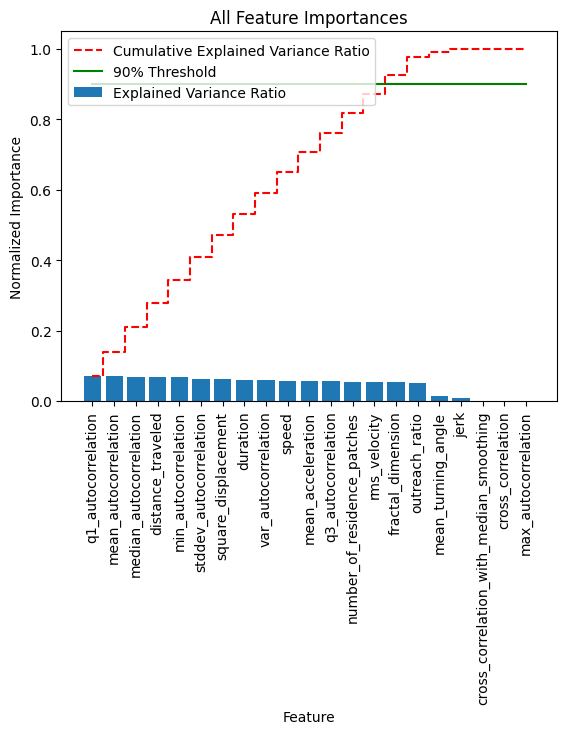

In [148]:
plt.bar(np.arange(1, 22), importances_df['importance'] / importances_df['importance'].sum(), label='Explained Variance Ratio')
plt.step(np.arange(1, 22), np.cumsum(importances_df['importance'] / importances_df['importance'].sum()), where='mid', label='Cumulative Explained Variance Ratio', color='red', linestyle='--')
plt.plot(np.arange(1, 22), [0.9 for _ in range(1, 22)], label='90% Threshold', color='green')
plt.xticks(np.arange(1, 22), importances_df['feature'].values, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('All Feature Importances')
plt.legend(loc='upper left')

In [154]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (502, 21)
y_train shape: (502,)

X_val shape: (126, 21)
y_val shape: (126,)


In [155]:
scaler = StandardScaler()

X_train_scl = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scl = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

In [156]:
X_train_scl

,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity,mean_autocorrelation,median_autocorrelation,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,-0.564873,-0.523053,-0.758510,0.457031,-0.685201,-0.566530,0.370486,-0.711150,0.522092,0.442300,...,0.0,0.579248,0.345935,-0.778165,-0.725870,-0.970954,-0.329314,-1.092315,-1.015683,0.026545
1,0.524852,-0.846509,0.111700,2.780630,-0.621671,0.302395,0.655308,0.609359,0.437083,0.434125,...,0.0,0.483252,0.304538,-0.641797,-0.538293,1.532768,-0.848729,-1.860902,1.461065,-0.792079
2,-0.642068,-0.025961,-0.589676,-0.596845,0.149933,0.274627,0.418284,-0.276556,0.603440,0.640162,...,0.0,0.569952,0.564206,-0.616769,-0.505647,0.093123,0.131095,0.541001,0.069462,0.481335
3,1.755822,-0.743204,1.738142,0.339300,-0.394832,-0.705975,-1.035352,1.441941,-1.537613,-1.343068,...,0.0,-1.999568,-0.496609,3.223629,2.441170,-1.080790,-0.898419,-0.352383,-0.903250,-0.883037
4,1.029499,-0.908304,1.031724,0.462117,-0.696219,-0.593944,-2.803165,0.983232,-0.965930,-1.177445,...,0.0,-0.765667,-0.969838,0.624414,0.739539,-0.529814,-0.936463,-0.442062,-0.175714,-0.792079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,-0.561052,0.068359,-0.642574,-0.205586,-0.354435,-0.283507,0.463583,-0.677755,0.351866,0.427013,...,0.0,0.301622,0.434055,-0.345462,-0.179286,-0.649897,0.226593,0.374366,-0.717835,0.526814
498,0.487621,1.194757,0.938088,-1.121979,1.398670,-0.347869,0.354574,0.354412,-1.546362,-1.278545,...,0.0,-1.194561,-2.898041,0.470019,0.610644,1.207530,0.234357,0.000470,1.122764,0.117503
499,-0.283155,-0.479183,-0.132624,0.112391,-0.461608,0.629991,0.493293,-0.244778,0.180105,0.195153,...,0.0,0.085553,0.332392,-0.191344,-0.011812,-0.362490,-0.493135,-0.033341,-0.424573,-0.564683
500,0.286229,0.184592,-0.217650,-0.162703,0.066798,-0.886894,0.253515,0.124103,0.697065,0.710149,...,0.0,0.713021,0.627423,-0.725664,-0.651568,-0.825259,-0.105709,1.234996,-0.707160,0.026545


In [157]:
X_val_scl

,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity,mean_autocorrelation,median_autocorrelation,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
0,0.593696,-0.402830,0.294383,0.362230,0.026189,-0.926089,0.290743,0.887334,0.177131,-0.041117,...,0.0,0.258410,0.079883,-0.540260,-0.408798,-1.167946,-0.593292,0.313639,-0.997940,-0.564683
1,-0.746769,-0.223481,-0.678056,-0.815565,-0.514883,-0.308678,0.292915,-0.851898,0.280645,0.342633,...,0.0,0.165943,0.536086,-0.099786,0.082827,0.179492,0.027833,0.903025,0.151818,0.572293
2,-1.382023,-1.166869,-0.815593,0.503575,-1.141244,2.285892,-0.875140,-1.421811,-1.241502,-1.293807,...,0.0,-0.913128,-1.836101,0.136082,0.312740,-0.598490,-0.894537,-1.730359,-0.283040,-0.792079
3,0.114880,-0.035932,-0.366345,0.069417,0.069179,-0.695602,-0.285094,0.257042,0.719784,0.735308,...,0.0,0.765173,0.510032,-0.866015,-0.857071,-1.123396,-0.198101,0.442562,-1.000545,-0.246330
4,1.933992,0.557778,2.057425,-1.049691,1.381276,-0.541608,0.323138,1.729491,-1.779791,-1.992884,...,0.0,-1.308838,-2.426200,1.037098,1.062167,1.231548,-0.435681,1.411715,1.277336,-0.792079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.596890,-0.066028,-0.394365,-0.422264,-0.179216,0.358709,0.470140,-0.503840,0.623395,0.720383,...,0.0,0.523724,0.824449,-0.345978,-0.179866,1.150920,0.012305,-0.312125,1.137802,0.117503
122,-0.152437,-0.745249,-0.051859,0.662520,-0.696814,0.185621,-0.286893,0.061856,-0.441872,-0.250564,...,0.0,-0.581756,-0.108218,0.611335,0.728811,-0.111421,-0.641429,-1.015175,-0.126080,-0.428246
123,0.803054,2.183060,1.092207,-1.186788,3.155837,-0.396990,0.386252,0.866922,-1.396606,-1.524349,...,0.0,-1.075608,-2.063265,0.610389,0.728034,-0.377838,0.634982,0.804778,-0.421640,0.435856
124,-0.431119,-0.448642,-0.521497,0.123905,-0.523481,-0.577402,-0.885420,-0.309749,1.259356,1.155105,...,0.0,1.372229,0.909631,-1.210577,-1.508964,-1.221553,-0.320773,-0.687656,-1.157245,-0.246330


In [158]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scl, y_train)

RandomForestClassifier(random_state=42)

In [159]:
perm_importance = permutation_importance(rf, X_val_scl, y_val, n_repeats=10, random_state=42)
perm_importance.importances_mean

array([ 6.34920635e-03, -3.96825397e-03,  4.12698413e-02,  1.66666667e-02,
        1.82539683e-02, -2.22044605e-17,  5.55555556e-03,  3.17460317e-03,
        9.52380952e-03,  7.93650794e-04, -7.93650794e-04,  0.00000000e+00,
        6.34920635e-03,  7.93650794e-03, -6.34920635e-03,  7.93650794e-03,
        7.93650794e-04,  2.38095238e-03, -9.52380952e-03,  3.17460317e-03,
        8.73015873e-03])

In [160]:
importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

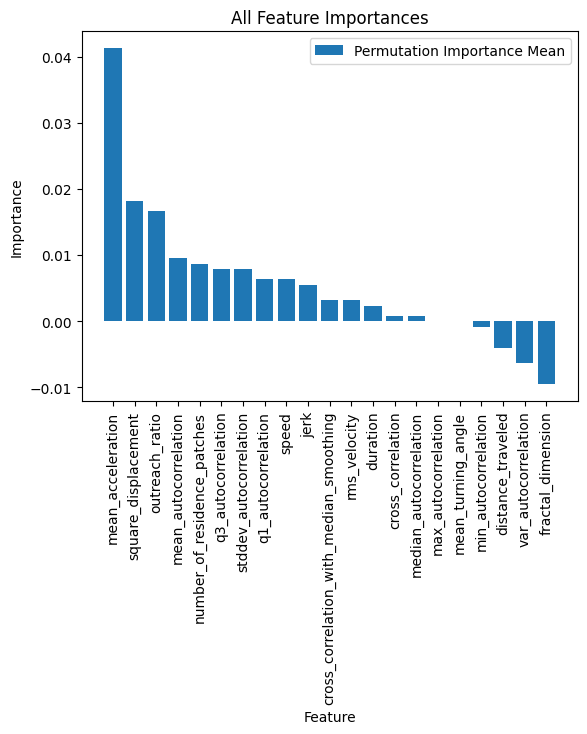

In [161]:
plt.bar(np.arange(1, 22), importances_df['importance'].values, label='Permutation Importance Mean')
# plt.step(np.arange(1, 22), np.cumsum(importances_df['importance'].values), where='mid', label='Cumulative Impurity-Based Importance', color='red', linestyle='--')
# plt.plot(np.arange(1, 22), [0.9 for _ in range(1, 22)], label='90% Threshold', color='green')
plt.xticks(np.arange(1, 22), importances_df['feature'].values, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('All Feature Importances')
plt.legend()

In [150]:
covariance_matrix = X_scl.cov()
covariance_matrix

,speed,distance_traveled,mean_acceleration,outreach_ratio,square_displacement,mean_turning_angle,jerk,rms_velocity,mean_autocorrelation,median_autocorrelation,...,max_autocorrelation,q1_autocorrelation,q3_autocorrelation,var_autocorrelation,stddev_autocorrelation,cross_correlation,duration,fractal_dimension,cross_correlation_with_median_smoothing,number_of_residence_patches
speed,1.001595,-0.094679,0.903113,0.241735,0.294277,-0.507986,-0.251443,0.971130,-0.701660,-0.703863,...,0.0,-0.696422,-0.635954,0.646309,0.665166,-0.027651,-0.470222,-0.120339,-0.035189,-0.503454
distance_traveled,-0.094679,1.001595,-0.031076,-0.665705,0.854678,-0.016930,0.206722,-0.107998,0.303522,0.272545,...,0.0,0.302239,0.270659,-0.248042,-0.279598,0.038571,0.834579,0.669471,0.030467,0.706206
mean_acceleration,0.903113,-0.031076,1.001595,0.096968,0.372926,-0.288465,-0.221900,0.884267,-0.721201,-0.731532,...,0.0,-0.691190,-0.709940,0.601918,0.622557,-0.011267,-0.418205,-0.069215,-0.019902,-0.458247
outreach_ratio,0.241735,-0.665705,0.096968,1.001595,-0.537280,-0.089181,-0.236775,0.265297,-0.293299,-0.264366,...,0.0,-0.290607,-0.266524,0.226667,0.256641,0.005675,-0.592527,-0.842757,0.016039,-0.516643
square_displacement,0.294277,0.854678,0.372926,-0.537280,1.001595,-0.117516,0.130979,0.297131,-0.052821,-0.084023,...,0.0,-0.049845,-0.056700,0.057084,0.052527,0.038151,0.462545,0.546821,0.029610,0.328947
mean_turning_angle,-0.507986,-0.016930,-0.288465,-0.089181,-0.117516,1.001595,0.014630,-0.416670,0.238695,0.222268,...,0.0,0.283794,0.113380,-0.333196,-0.349459,0.037383,0.210953,-0.140610,0.050665,0.110175
jerk,-0.251443,0.206722,-0.221900,-0.236775,0.130979,0.014630,1.001595,-0.311153,0.270440,0.266108,...,0.0,0.245578,0.300545,-0.175970,-0.180692,-0.012989,0.217932,0.235919,-0.015403,0.204675
rms_velocity,0.971130,-0.107998,0.884267,0.265297,0.297131,-0.416670,-0.311153,1.001595,-0.694669,-0.696616,...,0.0,-0.680993,-0.649526,0.610259,0.634437,-0.016050,-0.470680,-0.167403,-0.016241,-0.499825
mean_autocorrelation,-0.701660,0.303522,-0.721201,-0.293299,-0.052821,0.238695,0.270440,-0.694669,1.001595,0.992715,...,0.0,0.987306,0.932085,-0.885079,-0.912612,0.009750,0.585189,0.320813,0.006322,0.618153
median_autocorrelation,-0.703863,0.272545,-0.731532,-0.264366,-0.084023,0.222268,0.266108,-0.696616,0.992715,1.001595,...,0.0,0.969478,0.937811,-0.859683,-0.882467,0.015376,0.558133,0.302430,0.010611,0.599546


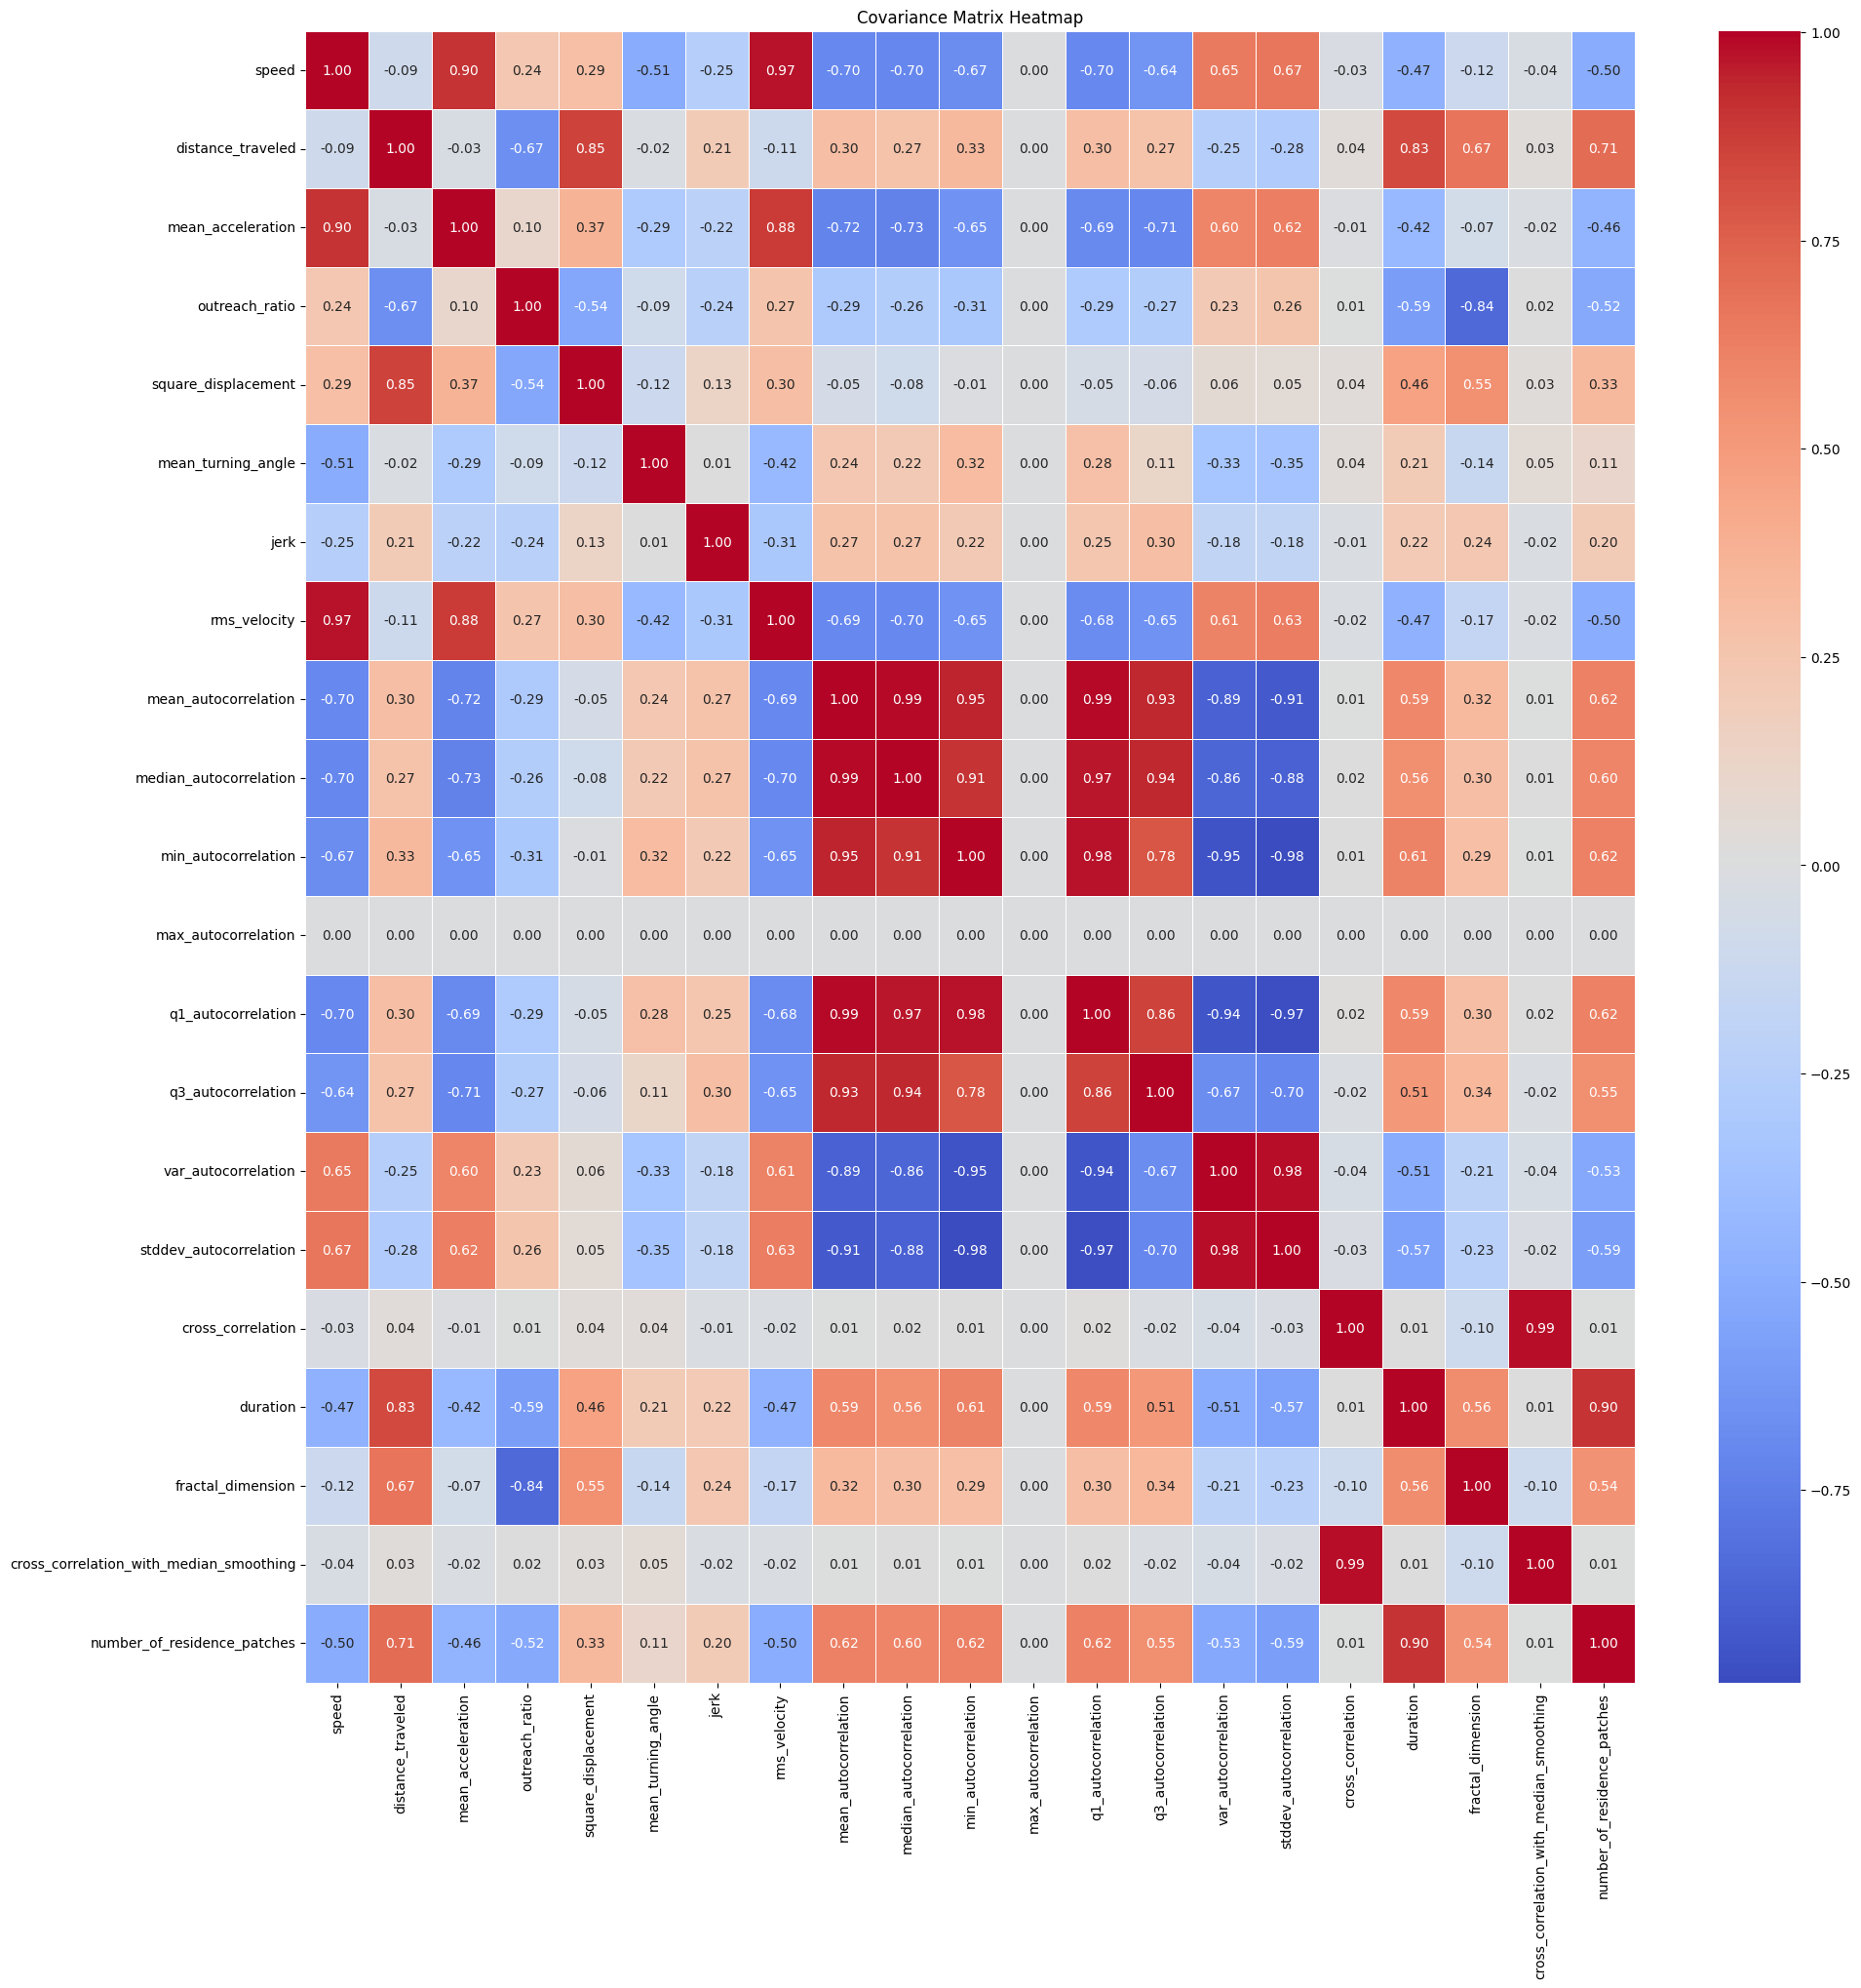

In [153]:
plt.figure(figsize=(22, 22))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()